## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs

import random
import time

from matplotlib import cm
from scipy.stats import zscore
from scipy.stats.stats import pearsonr
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.manifold import SpectralEmbedding

import umap

### Initial assumptions

In [2]:
# room dimensions in cm. (might break if changed)
width = 140
height = 140


# number of simulated place cells
n_cells = 50

## Place cell class

In [3]:
# place cell class

class PlaceCell(object):

    def __init__(self, mu, sigma):

        self.mu = mu
        self.sigma = sigma
        
    def gaussian(self, x):

        xm = x - self.mu
        sigma = self.sigma
        
        # factor1 = ((2*np.pi)**(-k/2)) * np.linalg.det(sigma)**(-1/2)              # normalization -- (turn into a number), peak firing rate
        factor1 = 4            # peak firing rate/ amplitude
        factor2 = (np.exp((-1/2) * xm.T @ np.linalg.inv(sigma) @ xm))
        result = factor1 * factor2
        
        return result
        
    def activity(self, x):
        activity = np.random.poisson(self.gaussian(x))
        # activity = self.gaussian(x)

        return activity

## Generating and plotting place cells

### Test cell

In [4]:
# test cell

testMu = np.array([[70],    #width
                   [70]])   #height
testSigma = np.array([[80, 0],
                      [0, 80]])
                      
testCell = PlaceCell(testMu, testSigma)

In [5]:
foobar = []
for i in range(40000):
    foobar.append(testCell.activity(testMu))

In [6]:
print(len(foobar))
np.mean(foobar)

40000


3.9947

### Plotting test cell

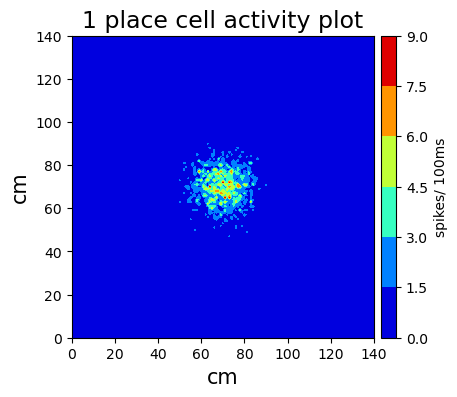

In [7]:
### plotting testCell ###

def plotTestCell(height = height, width = width):
    # be mindful of x and y indicies

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    Z = np.zeros((yLen, xLen))

    for y in range(yLen):
        for x in range(xLen):
            element = np.array([[x_coordinates[x]],                         # important to be careful about the indexing
                                [y_coordinates[y]]])
            result = testCell.activity(element)
            Z[y][x] = result

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')     # vmin=0, vmax=20
    plt.colorbar(label = 'spikes/ 100ms', pad = -0.17)
    plt.title("1 place cell activity plot", size = 17)
    plt.xlabel("cm", size = 15)
    plt.ylabel("cm", size = 15)
    plt.axis('square')
    plt.show()
    pass
    
# np.random.seed(10)
plotTestCell(height, width)

### Place Cells list

In [8]:
def generatePlaceCells(n_cells, sigma, height = height, width = width):

    cellsList = []
    for i in range(n_cells):
        # mu being location at which the cell is most active 
        mu = np.array([[random.uniform(0,width)],       # width
                       [random.uniform(0,height)]])     # height
        
        cellsList.append(PlaceCell(mu, sigma))
        
    return cellsList

In [9]:
# generating cells list

sigma = np.array([[80, 0],
                  [0, 80]])

# random.seed(10)
cellsList = generatePlaceCells(n_cells, sigma, height, width)

# # seedReset
# random.seed()

## Plotting the current place fields

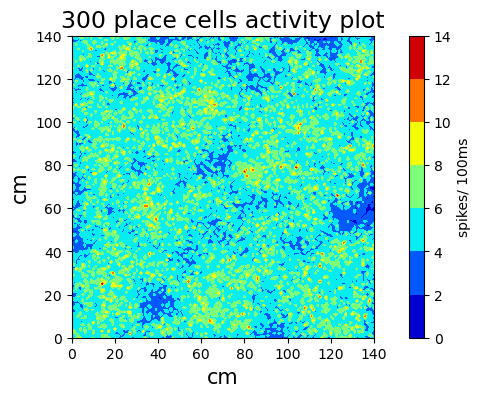

In [10]:
def plotCells(cellsList = cellsList, height = height, width = width):
    # be mindful of x and y indicies

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    Z = np.zeros((yLen, xLen))

    for y in range(yLen):
        for x in range(xLen):
            location = np.array([[x_coordinates[x]],                    # important to be careful about the indexing
                                 [y_coordinates[y]]])
            
            for placeCell in cellsList:
                locationActivity = placeCell.activity(location)

                if Z[y][x] < locationActivity:
                    Z[y][x] = locationActivity

    plt.figure(dpi=100)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    # plt.colorbar(label = 'spikes/ 100ms', pad = -0.17)
    plt.colorbar(label = 'spikes/ 100ms', pad = -0.05)

    plt.title(str(len(cellsList)) + " place cells activity plot", size = 17)
    plt.xlabel("cm", size = 15)
    plt.ylabel("cm", size = 15)
    plt.axis('square')
    plt.show()
    pass

# np.random.seed(10)
plotCells()

## Colormapping

In [11]:
def colormapLocation(coordinates, height = height, width = width):

    normalizeX = clrs.Normalize(vmin = 0, vmax = width)
    normalizeY = clrs.Normalize(vmin = 0, vmax = height)
    normX, normY = normalizeX(coordinates[0,:]), normalizeY(coordinates[1,:])

    # mapX = cm.get_cmap('Blues')
    # mapY = cm.get_cmap('Reds')
    mapX = cm.get_cmap('binary')
    mapY = cm.get_cmap('spring')

    colorValues_X = mapX(normX)
    colorValues_Y = mapY(normY)
    colorValues = (colorValues_X + colorValues_Y)/2

    return colorValues

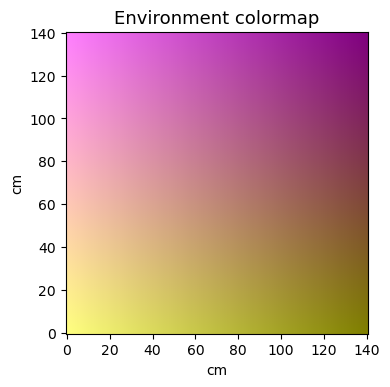

In [12]:
def plotColormapEnvironment(height = height, width = width):

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)
    xLen, yLen = len(x_coordinates), len(y_coordinates)

    dataLocation = []
    for y in y_coordinates:
        for x in x_coordinates:
            location = np.array([[x],      #width
                                 [y]])     #height
            dataLocation.append(location)

    colormap = colormapLocation(np.hstack(dataLocation))
    environmentColorMap = colormap.reshape(yLen, xLen, 4)       ### I am very confused by the orther of the dimensions now

    plt.figure(dpi=100)
    plt.clf()
    plt.imshow(environmentColorMap)

    ## Run the code without the ticks. Then, it chooses strange numbers for x-axis. There is also a minor problem with 140 tick. There is originally 141 coordinates for both axes
    plt.xticks([0,20,40,60,80,100,120,140])
    plt.yticks([0,20,40,60,80,100,120,140], [140,120,100,80,60,40,20,0])

    plt.title("Environment colormap", size = 13)
    plt.xlabel("cm")
    plt.ylabel("cm")
    plt.show()
    pass

plotColormapEnvironment()

# Generating data

### All-knowing mouse function (MasterMouse)

In [13]:
def masterMouse(cellsList, nSteps=1, height = height, width = width):

    # nSteps not used
    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)

    data = []
    dataLocation = []
    for y in y_coordinates:
        for x in x_coordinates:
            location = np.array([[x],      #width
                                 [y]])     #height
            # dataLocation.append(location)
            dataLocation.append(np.copy(location))

            sample = []
            for placeCell in cellsList:
                sample.append(placeCell.activity(location))
            # data.append(np.hstack(sample))
            data.append(np.hstack(np.copy(sample)))

    data = np.vstack(data)
    dataLocation = np.hstack(dataLocation)
    # dataLocation = np.vstack(dataLocation)

    return (data, dataLocation)

In [14]:
# t = 1000 * time.time() # current time in milliseconds
# np.random.seed(int(t) % 2**32)

(masterMouseData, masterMouseLocation) = masterMouse(cellsList)

In [15]:
print("masterMouseData shape is " + str(masterMouseData.shape))
print("masterMouseLocation shape is " + str(masterMouseLocation.shape))

masterMouseData shape is (19881, 300)
masterMouseLocation shape is (2, 19881)


### Randomly teleporting mouse function (RandomMouse)

In [16]:
def randomMouse(cellsList, nSteps, height = height, width = width):

    data = []
    dataLocation = []
    for i in range(nSteps):
        location = np.array([[random.uniform(0,width)],
                             [random.uniform(0,height)]])
        # dataLocation.append(location)
        dataLocation.append(np.copy(location))

        sample = []
        for placeCell in cellsList:
            sample.append(placeCell.activity(location))
        data.append(np.hstack(np.copy(sample)))
        
    data = np.vstack(data)
    dataLocation = np.hstack(dataLocation)
        
    return (data, dataLocation)

In [17]:
# np.random.seed(10)                # I think that if I set this seed then locations are not random (as intended), but also poisson random process is not random.

# t = 1000 * time.time()              # current time in milliseconds
# np.random.seed(int(t) % 2**32)      # reset the seed (if set), so it does not affect the Poisson random process

(randomMouseData, randomMouseLocation) = randomMouse(cellsList, 10000)         # SyntaxError: positional argument follows keyword argument

In [18]:
print("randomMouseData shape is " + str(randomMouseData.shape))
print("randomMouseLocation is " + str(randomMouseLocation.shape))

randomMouseData shape is (10000, 300)
randomMouseLocation is (2, 10000)


#### Generate spikes based on locations (helper function)

In [19]:
# function that generates spikes based on x and y coordinates

def generateSpikes(cellsList, coordinates):

    coordinates = np.hsplit(coordinates,len(coordinates[0,:]))
    data = []
    for location in coordinates:
        sample = []
        for placeCell in cellsList:
            sample.append(placeCell.activity(location))
        data.append(np.hstack(np.copy(sample)))

    data = np.vstack(data)
    
    return(data)

### Drunkard's walk

In [20]:
def drunkMouse(cellsList, nSteps, height = height, width = width):

    cm = 1
    movements = (np.array([[cm],[0]]), np.array([[-cm],[0]]), np.array([[0],[cm]]), np.array([[0],[-cm]]))

    dataLocation = []
    location = np.array([[width /2],        # first location is the middle of the environment
                         [height /2]])


    for i in range(nSteps):
        dataLocation.append(np.copy(location))      # append(location) was clearly mistake but how about append(location[:,:])
        nextMove = random.choice(movements)
        location += nextMove
        
        while (location[0,0] < 0 or location[0,0] > width) or (location[1,0] < 0 or location[1,0] > height):
            location -= nextMove
            nextMove = random.choice(movements)
            location += nextMove

    dataLocation = np.hstack(dataLocation)
    data = generateSpikes(cellsList, dataLocation)

    return (data, dataLocation)

In [21]:
# t = 1000 * time.time()              # current time in milliseconds
# np.random.seed(int(t) % 2**32)

drunkMouseData, drunkMouseLocation = drunkMouse(cellsList, 10000)

print("drunkMouseData shape is " + str(drunkMouseData.shape))
print("drunkMouseLocation is " + str(drunkMouseLocation.shape))

drunkMouseData shape is (10000, 300)
drunkMouseLocation is (2, 10000)


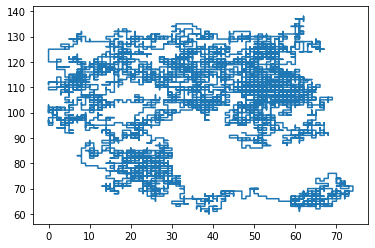

In [22]:
plt.plot(drunkMouseLocation[0,:], drunkMouseLocation[1,:])

### Linear Movement

In [23]:
def linearMouse(cellsList, nSteps= 60, height= height, width= width):

    cm = 1
    dataLocation = []
    location = np.array([[width /2],        # first location is the middle of the environment
                         [height /2]])

    movements = (np.array([[cm],[0]]), np.array([[-cm],[0]]), np.array([[0],[cm]]), np.array([[0],[-cm]]))
    nextMove = random.choice(movements)
    
    for i in range(nSteps):
        dataLocation.append(np.copy(location))
        location += nextMove
        
    dataLocation = np.hstack(dataLocation)
    data = generateSpikes(cellsList, dataLocation)

    return (data, dataLocation)

In [24]:
linearMouseData, linearMouseLocation = linearMouse(cellsList, nSteps= 70)

print("linearMouseData shape is " + str(linearMouseData.shape))
print("linearMouseLocation is " + str(linearMouseLocation.shape))

linearMouseData shape is (70, 300)
linearMouseLocation is (2, 70)


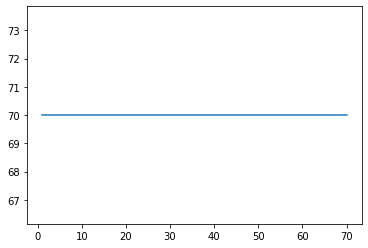

In [25]:
plt.plot(linearMouseLocation[0,:], linearMouseLocation[1,:])

# Generating trials

In [26]:
# ## adding master trials into 3D array

# def collectTrials(dataGenerator, numTrials, nSteps= 1):

#     dataList = []
#     locationList = []
#     for i in range(numTrials):
#         (data, location) = dataGenerator(cellsList, nSteps, height, width)

#         dataList.append(data)
#         locationList.append(location)

#     trialsData = np.stack(dataList)
#     trialsLocation = np.stack(locationList)

#     return trialsData, trialsLocation


In [27]:
# # trials master mouse
# trialsData, trialsLocation = collectTrials(masterMouse, 10)

# print(trialsData.shape)
# print(trialsLocation.shape)

In [28]:
# # trials random mouse
# trialsData, trialsLocation = collectTrials(randomMouse, 10, 20000)

# print(trialsData.shape)
# print(trialsLocation.shape)

In [29]:
# # trials drunkard's walk mouse
# trialsData_train, trialsLocation_train = collectTrials(drunkMouse, 200, 10000)
# trialsData_val, trialsLocation_val = collectTrials(drunkMouse, 200, 10000)

# print(trialsData_train.shape)
# print(trialsLocation_train.shape)

In [30]:
# trialsData, trialsLocation = collectTrials(linearMouse, 1000, nSteps= 70)

# print(trialsData.shape)
# print(trialsLocation.shape)

In [31]:
# linearMouseLocation = trialsLocation.reshape(2, 70000)          # look closely at what's happening here, the plot shuld not look like this
# plt.plot(linearMouseLocation[0,:], linearMouseLocation[1,:])

In [32]:
# np.save("/Users/jambormike/Documents/School/masters_project/code/project_2/tndm-main/notebooks/testData_train",trialsData_train)
# np.save("/Users/jambormike/Documents/School/masters_project/code/project_2/tndm-main/notebooks/testDataLocation_train",trialsLocation_train)

# np.save("/Users/jambormike/Documents/School/masters_project/code/project_2/tndm-main/notebooks/testData_val",trialsData_val)
# np.save("/Users/jambormike/Documents/School/masters_project/code/project_2/tndm-main/notebooks/testDataLocation_val",trialsLocation_val)

# MasterMouse data exploration

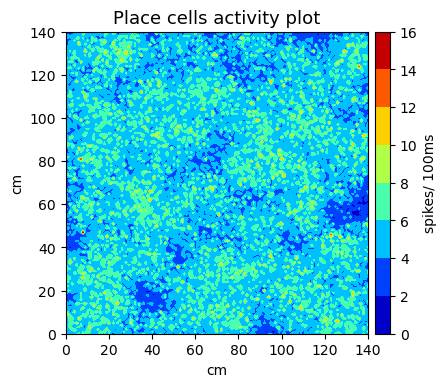

In [33]:
# Plotting ordered data function

def plotOrderedData(data, height= height, width= width, title= "title", units= "units", colorbarLabel= "colorbarLabel"):

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')
    Z = data[:, 0]

    for index in range(data.shape[1]):
        Z = np.maximum(Z, data[:, index])

    Z = Z.reshape(len(x_coordinates),len(y_coordinates))

    plt.figure(dpi=100)    # figsize=(width, height)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = colorbarLabel, pad = -0.17)
    plt.title(title, size = 13)
    plt.xlabel(units)
    plt.ylabel(units)
    plt.axis('square')
    plt.show()
    pass

plotOrderedData(masterMouseData, title= "Place cells activity plot", units= "cm", colorbarLabel= "spikes/ 100ms")

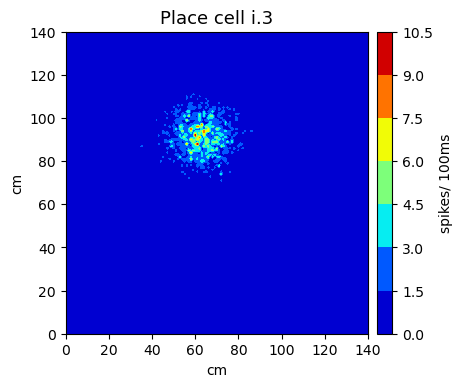

In [34]:
# Turning master mouse data into room plot

def plotDataCell(data, index= 0, height= height, width= width, title= "title", units= "units", colorbarLabel= "colorbarLabel"):

    cell = data[:,index]

    x_coordinates = np.arange(start=0, stop= width +1, step=1)
    y_coordinates = np.arange(start=0, stop= height +1, step=1)

    X, Y = np.meshgrid(x_coordinates, y_coordinates, indexing = 'xy')

    Z = cell.reshape(len(x_coordinates),len(y_coordinates))


    plt.figure(dpi=100)    # figsize=(width, height)
    plt.clf()
    plt.contourf(X, Y, Z, cmap = 'jet')
    plt.colorbar(label = colorbarLabel, pad = -0.16)
    plt.title(title, size = 13)
    plt.xlabel(units)
    plt.ylabel(units)
    plt.axis('square')
    plt.show()

    pass

index = 3
plotDataCell(data= masterMouseData, index= index, title= ("Place cell i." + str(index)), units = "cm", colorbarLabel= "spikes/ 100ms")

## Master Mouse PCA

In [35]:
masterZscore = zscore(masterMouseData)
masterZscore = np.nan_to_num(masterZscore)                                       ## Do I need this here?

masterMousePCA = PCA()
masterMousePCA.fit(masterZscore)

masterWeights = masterMousePCA.components_                                       # eigenvectors ordered by eigenvalues
masterVariance = masterMousePCA.explained_variance_                              # eigenvalues
masterExplainedVariance = np.cumsum(masterVariance)/np.sum(masterVariance)
masterPCA_scores = masterMousePCA.transform(masterZscore)                            # latent variables

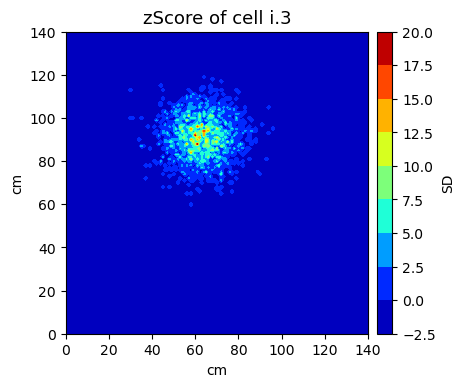

In [36]:
index = 3
plotDataCell(data= masterZscore, index= index, title= ("zScore of cell i." + str(index)), units= "cm", colorbarLabel= "SD")

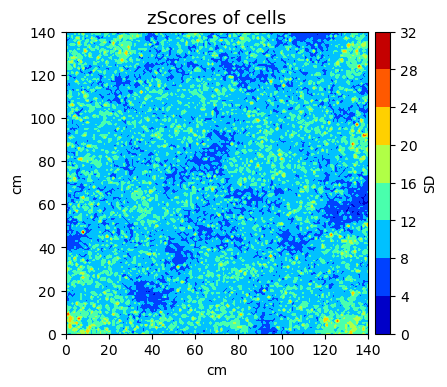

In [37]:
plotOrderedData(masterZscore, title= "zScores of cells", units= "cm", colorbarLabel= "SD")

In [38]:
def plotVariance(variance):
    '''
    Plots variance (eigenvalues)
    Args:
        (numpy array of floats) : Vector of eigenvalues   ### look at the shape of the vector
    Returns:
        Nothing
    '''
    plt.figure(dpi=100, figsize=(6, 4))             # figsize=(?, 4)
    plt.clf()
    plt.plot(np.arange(1, len(variance) + 1), variance, 'o-k')

    # plt.loglog(np.arange(1, len(variance) + 1), variance, 'o-k')

    plt.title('Scree plot', size = 13)
    plt.xlabel('Component')
    plt.xticks(np.arange(0, len(variance)+1))                       ### is there a better way of doing this
    plt.ylabel('Variance')                                          ### eigenvalues
    plt.yticks(np.arange(0, max(variance)+0.25, step=0.25))
    plt.grid()
    plt.show()
    
    pass

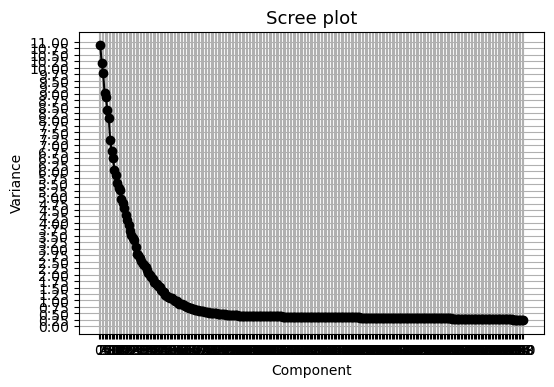

In [39]:
plotVariance(masterMousePCA.explained_variance_)

In [40]:
def plotVarianceExplained(explainedVariance):
    """
    Plots explained variance ratio
    Args:
        explainedVarianceRatio (numpy array of floats) : Vector of variance explained
                                                         for each PC
    Returns:
        Nothing.
    """
    plt.figure(dpi=100, figsize=(6, 4))
    plt.clf()
    plt.plot(np.arange(1, len(explainedVariance) + 1), explainedVariance, 'o-k')

    plt.title('Cumulative sum of explained variance', size = 13)

    plt.xlabel('Number of components')
    plt.xticks(np.arange(0, len(explainedVariance)+1))                  ### is there a better way of doing this
    plt.ylabel('Variance explained')
    plt.yticks(np.arange(0, max(explainedVariance)+0.05, step=0.1))

    plt.grid()
    plt.show()

    pass

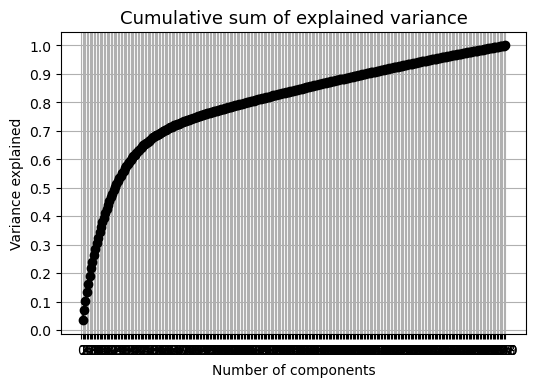

In [41]:
masterExplainedVariance = np.cumsum(masterMousePCA.explained_variance_)/np.sum(masterMousePCA.explained_variance_)
plotVarianceExplained(masterExplainedVariance)

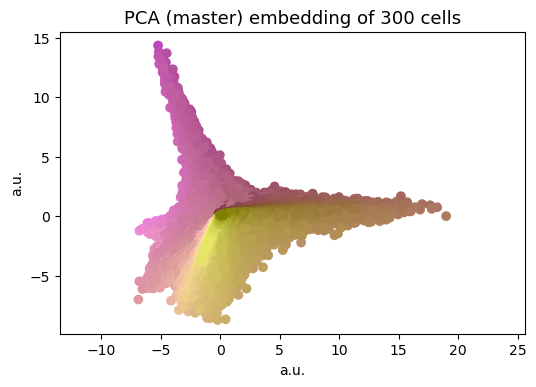

In [42]:
## plot two components

plt.figure(dpi=100)
plt.scatter(masterPCA_scores[:, 0], masterPCA_scores[:, 1], c= colormapLocation(masterMouseLocation))

plt.title(("PCA (master) embedding of " + str(n_cells) + " cells"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

In [43]:
## plot three components

def plotThreeComponents(scores, location):
    '''
    plot first three components (latent variables) in 3D scatter plot
    Args:
        scores: latent variables matrix from PCA
    Returns:
        Nothing.
    '''

    # %matplotlib notebook              # does not work in VS code

    lv_1, lv_2, lv_3 = scores[:,0], scores[:,1], scores[:,2]
    colorMap = colormapLocation(location)

    plt.figure(dpi=100, figsize=(7,7))
    plt.clf()
    # plt.title('First three principal components scatter plot')

    ax = plt.axes(projection='3d')
    # ax.scatter3D(lv_1, lv_2, lv_3, s = 4)
    ax.scatter3D(lv_1, lv_2, lv_3, c= colorMap, s = 4)
    
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    # ax.view_init(30,30)

    plt.show()
    pass

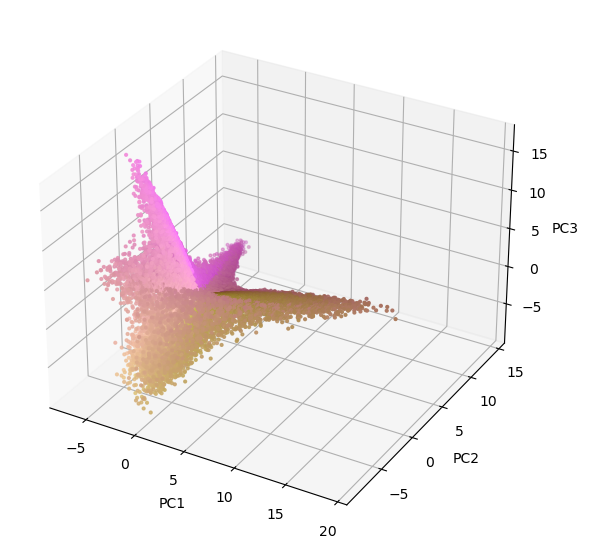

In [44]:
plotThreeComponents(masterPCA_scores,masterMouseLocation)

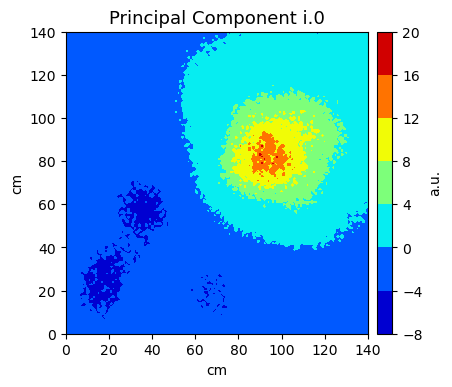

In [45]:
index = 0
plotDataCell(data= masterPCA_scores, index= index, title= ("Principal Component i." + str(index)), units= "cm", colorbarLabel= "a.u.")

### Data reconstruction

In [46]:
# # Master Scores by hand
# masterScoresByHand = masterZscore @ masterWeights

# K = 100

# masterScoresByHandCut = masterScoresByHand[:, :K]
# masterWeightsCut = masterWeights[:, :K]

# dataRecon = masterScoresByHandCut @ masterWeightsCut.T     #this should give me back approximation of masterZscore

# # plotDataCell(dataRecon, 0)

# plotOrderedData(dataRecon)

## MasterMouse ICA

In [47]:
# masterICA = FastICA()
# masterICA.fit(masterZscore)
# masterICAdata = masterICA.transform(masterZscore)

# plotOrderedData(masterICAdata)

In [48]:
# index = 0
# plotDataCell(data= masterICAdata, index= index, title= ("Independent Component i." + str(index)), units= "cm", colorbarLabel= "a.u.")

# Random Mouse Data Exploration

In [49]:
randomZscore = zscore(randomMouseData)
randomZscore = np.nan_to_num(randomZscore)

randomMousePCA = PCA()
randomMousePCA.fit(randomZscore)

randomWeights = randomMousePCA.components_                                     # eigenvectors ordered by eigenvalues
randomVariance = randomMousePCA.explained_variance_                            # eigenvalues
randomExplainedVariance = np.cumsum(randomVariance)/np.sum(randomVariance)
randomPCA_scores = randomMousePCA.transform(randomZscore)                          #latent variables

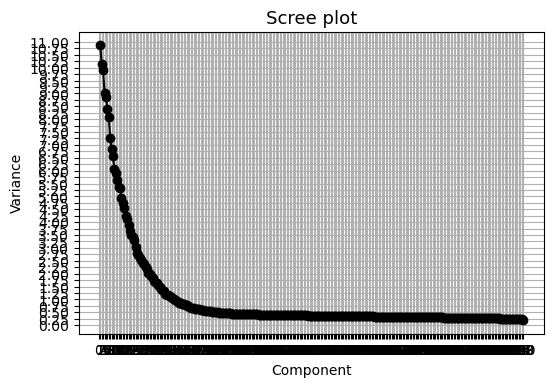

In [50]:
plotVariance(randomMousePCA.explained_variance_)

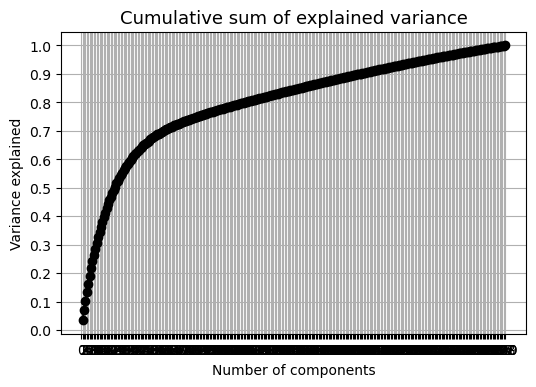

In [51]:
randomExplainedVariance = np.cumsum(randomMousePCA.explained_variance_)/np.sum(randomMousePCA.explained_variance_)
plotVarianceExplained(randomExplainedVariance)

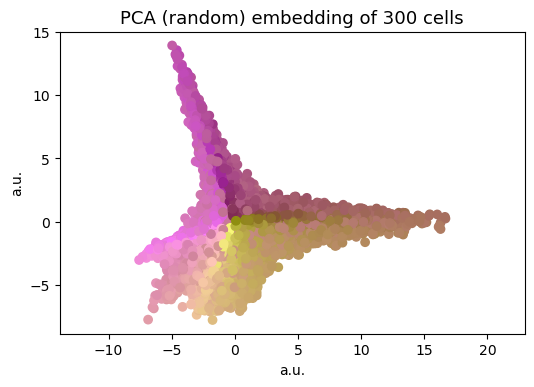

In [52]:
## plot two components

plt.figure(dpi=100)
plt.scatter(randomPCA_scores[:, 0], randomPCA_scores[:, 1], c= colormapLocation(randomMouseLocation))

plt.title(("PCA (random) embedding of " + str(n_cells) + " cells"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

## First 3 components in 3D

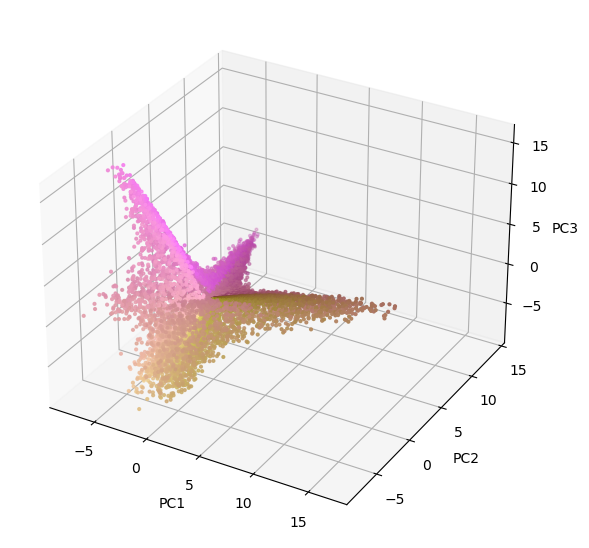

In [53]:
## plot three components

plotThreeComponents(randomPCA_scores, randomMouseLocation)

### Data reconstruction

In [54]:
# # Master Scores by hand
# masterScoresByHand = masterZscore @ masterWeights

# K = 100

# masterScoresByHandCut = masterScoresByHand[:, :K]
# randomWeightsCut = randomWeights[:, :K]

# dataRecon = masterScoresByHandCut @ randomWeightsCut.T     #this should give me back approximation of masterZscore

# # plotDataCell(dataRecon, 15)
# plotOrderedData(dataRecon)

### RandomMouse ICA

In [55]:
# randomICA = FastICA()
# randomICA.fit(randomZscore)
# randomICAdata = randomICA.transform(randomZscore)

# plotDataCell(randomICAdata, 0)
# plt.show()

# UMAP

## Master

In [56]:
masterReducer = umap.UMAP()     # n_neighbors=
masterUMAP_embedding = masterReducer.fit_transform(masterZscore)

print(masterUMAP_embedding.shape)


(19881, 2)


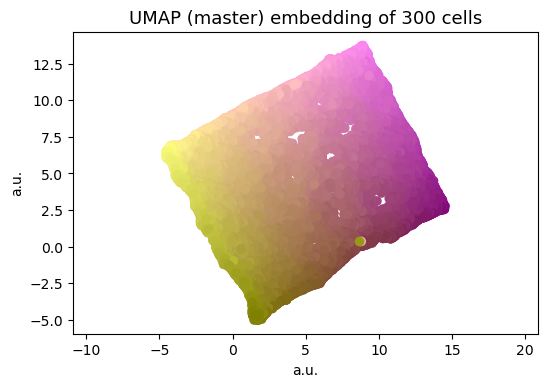

In [57]:
plt.figure(dpi=100)
plt.scatter(masterUMAP_embedding[:, 0], masterUMAP_embedding[:, 1], c= colormapLocation(masterMouseLocation))

plt.title(("UMAP (master) embedding of " + str(n_cells) + " cells"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

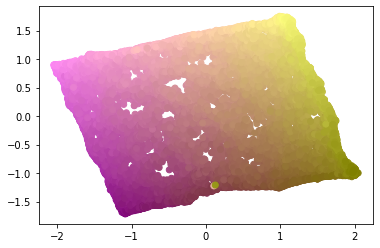

In [58]:
## PCA on master UMAP

umapZscore = zscore(masterUMAP_embedding)
umapZscore = np.nan_to_num(umapZscore)                                       ## Do I need this here?

umapMousePCA = PCA()
umapMousePCA.fit(umapZscore)

umapWeights = umapMousePCA.components_                                       # eigenvectors ordered by eigenvalues
umapVariance = umapMousePCA.explained_variance_                              # eigenvalues
umapExplainedVariance = np.cumsum(umapVariance)/np.sum(umapVariance)
umapScores = umapMousePCA.transform(umapZscore)                            # latent variables


plt.scatter(umapScores[:, 0], umapScores[:, 1], c= colormapLocation(masterMouseLocation))

## Random

In [59]:
randomReducer = umap.UMAP()     # n_neighbors=
randomUMAP_embedding = randomReducer.fit_transform(randomZscore)

print(randomUMAP_embedding.shape)

(10000, 2)


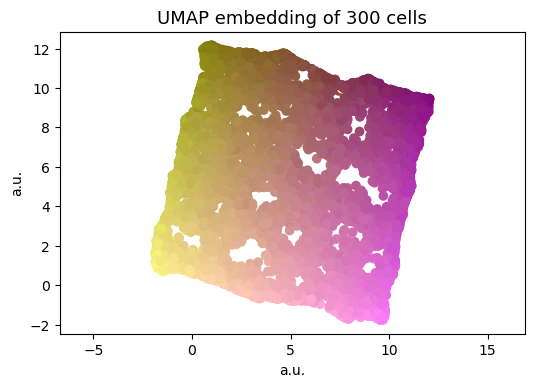

In [60]:
plt.figure(dpi=100)    # figsize=(width, height)
plt.scatter(randomUMAP_embedding[:, 0], randomUMAP_embedding[:, 1], c= colormapLocation(randomMouseLocation))

plt.title(("UMAP embedding of " + str(n_cells) + " cells"), size= 13)
plt.xlabel("a.u.")
plt.ylabel("a.u.")

plt.gca().set_aspect('equal', 'datalim')

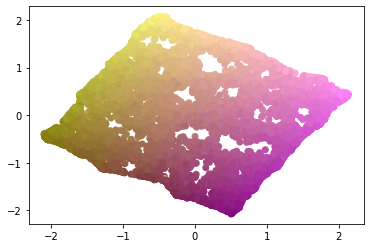

In [61]:
## PCA on  master UMAP

umapZscore = zscore(randomUMAP_embedding)
umapZscore = np.nan_to_num(umapZscore)                                       ## Do I need this here?

umapMousePCA = PCA()
umapMousePCA.fit(umapZscore)

umapWeights = umapMousePCA.components_                                       # eigenvectors ordered by eigenvalues
umapVariance = umapMousePCA.explained_variance_                              # eigenvalues
umapExplainedVariance = np.cumsum(umapVariance)/np.sum(umapVariance)
umapScores = umapMousePCA.transform(umapZscore)                            # latent variables


plt.scatter(umapScores[:, 0], umapScores[:, 1], c= colormapLocation(randomMouseLocation))

# Laplacian Eigenmaps (Spectral Embedding)

## Master

In [62]:
# masterLaplacian = SpectralEmbedding(n_components = 2)
# masterLaplacianEmbedding = masterLaplacian.fit_transform(masterZscore)


In [63]:
# plt.figure(dpi=100)
# plt.scatter(masterLaplacianEmbedding[:, 0], masterLaplacianEmbedding[:, 1], c= colormapLocation(masterMouseLocation))

# plt.title(("Laplacian (master) embedding of " + str(n_cells) + " cells"), size= 13)
# plt.xlabel("a.u.")
# plt.ylabel("a.u.")

# plt.gca().set_aspect('equal', 'datalim')

#### Save/load data

In [64]:
# masterLaplacianEmbedding = np.load("masterLaplacianEmbedding_100n_run1.npy")
# masterMouseLocation = np.load("masterMouseLocation_100n_run1.npy")

In [65]:
# np.save("masterLaplacianEmbedding_100n_run1.npy", masterLaplacianEmbedding)
# np.save("masterMouseDataLocation_100n_run1.npy", masterMouseLocation)

## Random

In [66]:
# randomLaplacian = SpectralEmbedding(n_components = 2)
# randomLaplacianEmbedding = randomLaplacian.fit_transform(randomZscore)


In [67]:
# plt.figure(dpi=100)
# plt.scatter(randomLaplacianEmbedding[:, 0], randomLaplacianEmbedding[:, 1], c= colormapLocation(randomMouseLocation))

# plt.title(("Laplacian embedding of " + str(n_cells) + " cells"), size= 13)
# plt.xlabel("a.u.")
# plt.ylabel("a.u.")

# plt.gca().set_aspect('equal', 'datalim')

#### Save/load data

In [68]:
# randomLaplacianEmbedding = np.load("randomLaplacianEmbedding_20n_run1.npy")
# randomMouseLocation = np.load("randomMouseDataLocation_20n_run1.npy")

In [69]:
# np.save("randomLaplacianEmbedding_100n_run1.npy", randomLaplacianEmbedding)
# np.save("randomMouseLocation_100n_run1.npy", randomMouseLocation)

# Comparing distances

In [70]:
masterPCA_scores_transpose = masterPCA_scores.T[:2,:]
masterUMAP_embedding_transpose = masterUMAP_embedding.T
# masterLaplacianEmbedding_transpose = masterLaplacianEmbedding.T

In [71]:
randomPCA_scores_transpose = randomPCA_scores.T[:2,:]
randomUMAP_embedding_transpose = randomUMAP_embedding.T
# randomLaplacianEmbedding_transpose = randomLaplacianEmbedding.T

In [72]:
print("randomMouseLocation shape is", randomMouseLocation.shape)
print("randomPCA_scores_transpose shape is", randomPCA_scores_transpose.shape)
print("randomUMAP_embedding_transpose shape is", randomUMAP_embedding_transpose.shape)
# print("randomLaplacianEmbedding_transpose shape is", randomLaplacianEmbedding_transpose.shape)

randomMouseLocation shape is (2, 10000)
randomPCA_scores_transpose shape is (2, 10000)
randomUMAP_embedding_transpose shape is (2, 10000)


In [73]:
def pickRandomLocations(locations, number_of_samples= 15):
    locationsLength = locations.shape[1]

    samples = random.sample(range(locationsLength), number_of_samples)

    return samples

# coordinate_indicies = pickRandomLocations(masterMouseLocation, 10000)
coordinate_indicies = pickRandomLocations(randomMouseLocation, 10000)

In [74]:
# def distanceMeasure(coordinates, coordinate_indicies):

#     locations = []
#     for i in coordinate_indicies:
#         locations.append(coordinates[: , i])

#     locations_copy = locations.copy()
#     used_locations = []
#     cumulative_distance = []

#     for i in range(len(locations)):
#         current_coordinate = locations_copy.pop(0)
#         distance = 0
#         for loc in used_locations:
#             distance += np.linalg.norm(current_coordinate - loc)
        
#         ## it might be worthwhile to look into this
#         # try:
#         #     distance += cumulative_distance[-1]
#         # except IndexError:
#         #     distance += 0

#         cumulative_distance.append(distance)
#         used_locations.append(current_coordinate)

#     return cumulative_distance

In [75]:
def distanceMeasure(coordinates, coordinate_indicies):

    locations = []
    for i in coordinate_indicies:
        locations.append(coordinates[: , i])

    locations_copy = locations.copy()
    used_locations = []
    cumulative_distance = []

    for i in range(len(locations)):
        current_coordinate = locations_copy.pop(0)
        try:
            distance = np.linalg.norm(current_coordinate - used_locations[-1])
        except IndexError:
            distance = 0

        cumulative_distance.append(distance)
        used_locations.append(current_coordinate)

    return cumulative_distance[1:]

In [76]:
master_real_distance = distanceMeasure(masterMouseLocation, coordinate_indicies)
master_umap_distance = distanceMeasure(masterUMAP_embedding_transpose, coordinate_indicies)
master_pca_distance = distanceMeasure(masterPCA_scores_transpose, coordinate_indicies)
# master_laplacian_distance = distanceMeasure(masterLaplacianEmbedding_transpose, coordinate_indicies)


Text(0, 0.5, 'units')

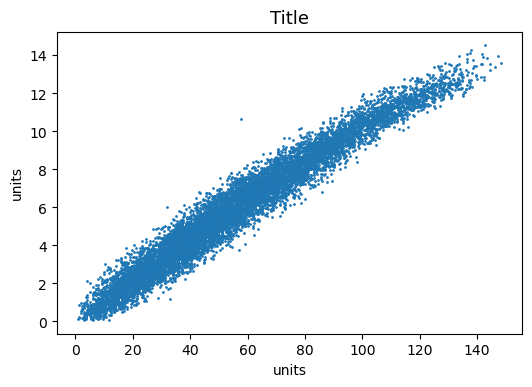

In [77]:
plt.figure(dpi=100)

plt.scatter(master_real_distance, master_umap_distance, s= 1)

plt.title(("Title"), size= 13)
plt.xlabel("units")
plt.ylabel("units")


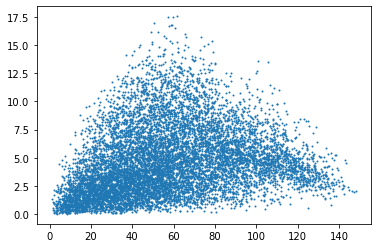

In [78]:
plt.scatter(master_real_distance, master_pca_distance, s= 1)

In [79]:
# plt.scatter(master_real_distance, master_laplacian_distance, s= 1)

In [80]:
print(pearsonr(master_real_distance, master_umap_distance))
print(pearsonr(master_real_distance, master_pca_distance))
# print(pearsonr(master_real_distance, master_laplacian_distance))

(0.9765275466055033, 0.0)
(0.24121593550987155, 2.4303059036069643e-132)


In [81]:
random_real_distance = distanceMeasure(randomMouseLocation, coordinate_indicies)
random_umap_distance = distanceMeasure(randomUMAP_embedding_transpose, coordinate_indicies)
random_pca_distance = distanceMeasure(randomPCA_scores_transpose, coordinate_indicies)
# random_laplacian_distance = distanceMeasure(randomLaplacianEmbedding_transpose, coordinate_indicies)

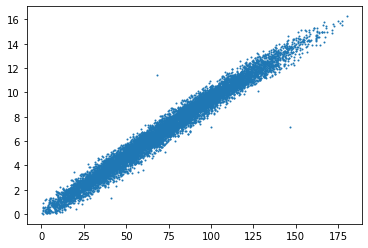

In [82]:
plt.scatter(random_real_distance, random_umap_distance, s= 1)

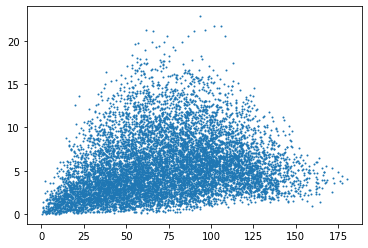

In [83]:
plt.scatter(random_real_distance, random_pca_distance, s= 1)

In [84]:
# plt.scatter(random_real_distance, random_laplacian_distance, s= 1)

In [85]:
print(pearsonr(random_real_distance, random_umap_distance))
print(pearsonr(random_real_distance, random_pca_distance))
# print(pearsonr(random_real_distance, random_laplacian_distance))

(0.9869271586583372, 0.0)
(0.22910247387923494, 3.162502092591899e-119)


# ---------------------------------------------------------------------------------------------------------------

# Notes, tests, nonsense, etc.

In [86]:
# # dev version of realDistanceMeasure

# coordinates = np.array([[5,2,10,5,1],
#                         [3,2,0,9,1]])

# def realDistanceMeasure(coordinates, coordinate_indicies):

#     locations = []
#     # for i in coordinate_indicies:
#     for i in range(5):
#         locations.append(coordinates[: , i])

#     locations_copy = locations.copy()
#     used_locations = []
#     cumulative_distance = []

#     for i in range(len(locations)):
#         print("i EQUALS", i)
#         current_coordinate = locations_copy.pop(0)
#         print("CURRENT COORDINATE IS", current_coordinate)
#         print("used_locations are", used_locations)

#         try:
#             distance = np.linalg.norm(current_coordinate - used_locations[-1])
#         except IndexError:
#             distance = 0

#         print("distance is", distance)
        
#         cumulative_distance.append(distance)
#         print("cummulative distance is", cumulative_distance)
#         used_locations.append(current_coordinate)

#     print("final used locationd are", used_locations )
#     return cumulative_distance

# # foo = realDistanceMeasure(masterMouseLocation, coordinate_indicies)
# foo = realDistanceMeasure(coordinates, coordinate_indicies)
# print(foo)

In [87]:
# # dev version of realDistanceMeasure

# coordinates = np.array([[5,2,10,5,1],
#                         [3,2,0,9,1]])

# def realDistanceMeasure(coordinates, coordinate_indicies):

#     locations = []
#     # for i in coordinate_indicies:
#     for i in range(5):
#         locations.append(coordinates[: , i])

#     locations_copy = locations.copy()
#     used_locations = []
#     cumulative_distance = []

#     for i in range(len(locations)):
#         print("i EQUALS", i)
#         current_coordinate = locations_copy.pop(0)
#         print("CURRENT COORDINATE IS", current_coordinate)
#         print("used_locations are", used_locations)
#         distance = 0
#         for loc in used_locations:
#             print("current loc is", loc)
#             distance += np.linalg.norm(current_coordinate - loc)
#             print("currebnt norm is", np.linalg.norm(current_coordinate - loc))
#             print("distance is", distance)
        
#         # try:
#         #     distance += cumulative_distance[-1]
#         # except IndexError:
#         #     distance += 0
        
#         cumulative_distance.append(distance)
#         print("cummulative distance is", cumulative_distance)
#         used_locations.append(current_coordinate)

#     print("final used locationd are", used_locations )
#     return cumulative_distance

# # foo = realDistanceMeasure(masterMouseLocation, coordinate_indicies)
# foo = realDistanceMeasure(coordinates, coordinate_indicies)
# print(foo)